<a href="https://colab.research.google.com/github/Ybahanni/Crypto_bot_1/blob/master/Practical_session_2_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





**MULTIPLE INSTANCE LEARNING USING PYTORCH: HISTOLOGICAL CLASSIFICATION**

In this practical session, students will explore the concept of M**ultiple Instance Learning (MIL)** for image classification using features extracted with the **CONCH model**, a foundation model designed for efficient and scalable feature extraction. The session will begin with students **dividing whole-slide images into smaller, non-overlapping patches**. For each patch, they will **extract features using the CONCH model** to create high-quality feature representations. After feature extraction, students will implement a **MIL classifier** using PyTorch, where the goal is to perform **bag-level classification**.

**Exercise 1**: **Extracting Patches from Whole-Slide Images using OpenSlide and Filtering Background.** In this exercise, students will learn how to divide a Whole-Slide Image (WSI) into smaller patches, filter out patches that contain too much background (white areas), and save the valid patches as images. This process is critical in digital pathology tasks, where the goal is to focus on the tissue regions of the slide.
![texto del enlace](https://drive.google.com/uc?id=1rTJZm9tnt0Lu58W2CWyUFJRefpr5FpUd)

In [1]:
# Importing required libraries
import os
import numpy as np
import cv2
from google.colab import drive

In [2]:
# Install OpenSlide for reading whole-slide images. Read the documentation of openslide!
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 1s (118 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.

In [3]:
import openslide #Import openslide library
drive.mount('/content/drive')  # Mount Google Drive to access files

Mounted at /content/drive


It is crucial to first divide the Whole Slide Image (WSI), which is typically very large, into smaller patches for processing. However, it is equally important to design a function that **filters out patches lacking sufficient tissue**. This ensures that only relevant areas containing useful information are analyzed, eliminating patches that consist mostly of background or empty space. We are going to define the function that removes patches without tissue. We are going to develop the function `isWhitePatch` that we will integrate later in the `extract_patches` function.








In [4]:
# Function to check if a patch is mostly white (background).

def isWhitePatch(patch, satThresh=5):
    """
    Checks if the image patch is mostly white (background) by converting it to HSV color space
    and measuring the saturation. Low saturation means the patch is likely to be background.
    Args:
    - patch: The image patch in RGB format.
    - satThresh: Threshold for determining if the patch is white (default = 5).
    Returns:
    - True if the patch is mostly white, False otherwise.
    """
    # Convert the patch from RGB to HSV use the function  cv2.cvtColor
    patch_hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)

    # Extract the saturation channel from the HSV image
    s = patch_hsv[:, :, 1]

    # Check if the mean saturation value (first channel of the patch_hsv image) is below the threshold
    if np.mean(s) < satThresh:
        return True  # The patch is mostly white
    else:
        return False  # The patch contains non-white areas

Next we will proceed to develop the function that will patch the whole slide

*   Élément de liste
*   Élément de liste

image (WSI), `extract_patches`.

In [5]:
import os
import numpy as np
import openslide

def extract_patches(path, slide_id, patch_size, patch_level, path_patches, save_patches=False):
    """
    Extract non-overlapping patches from a Whole Slide Image (WSI).

    Args:
    - path: The directory where the Whole-Slide Images (WSIs) are stored.
    - slide_id: The slide ID of the WSI file.
    - patch_size: The size of each patch (e.g., 1024x1024 pixels).
    - patch_level: The magnification level (e.g., 10x).
    - path_patches: Directory to save extracted patches.
    - save_patches: Whether to save the patches to disk (True) or not (False). Default is False.

    Returns:
    - valid_patches: A list of valid patches that are not mostly white.
    - patch_names: A list of corresponding patch names.
    """

    # Create the directory if it doesn't exist and save_patches is True
    if save_patches:
        os.makedirs(path_patches, exist_ok=True)

    # Load the Whole-Slide Image (WSI) using openslide.open_slide
    wsi = openslide.open_slide(os.path.join(path, slide_id))
    # Get dimensions at desired magnification level (patch_level) using wsi.level_dimensions in rows and columns
    w, h = wsi.level_dimensions[patch_level]

    # Read the region of interest at the specified magnification level
    wsi_image = wsi.read_region((0, 0), patch_level, (w, h)).convert('RGB')  # Load the entire image at the given level

    # List to store valid patches
    valid_patches = []
    # List to store patch names
    patch_names = []

    # Loop through the image and extract non-overlapping patches of the given size
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            # Define the region coordinates for the current patch, indicates where the patch starts in rows (x) and columns (y) and where it ends using patch_size
            region = (x, y, x + patch_size, y + patch_size)

            # Crop the patch from the WSI (wsi_image.crop) and convert to RGB
            patch = wsi_image.crop(region).convert('RGB')

            # Convert the patch to a NumPy array and check if it's mostly white (background)
            if isWhitePatch(np.array(patch), satThresh=5):
                continue  # Skip white patches

            # Accumulate valid patches in the list valid_patches (use append)
            valid_patches.append(patch)
            patch_name = slide_id + "_x" + str(x) + "_y" + str(y) + ".png"
            # Accumulate the patch name in the list patch_names
            patch_names.append(patch_name)

            # Save the patch as a PNG image only if save_patches is True
            if save_patches:
                # Save patch to the specified path
                patch.save(os.path.join(path_patches, patch_name))

    return valid_patches, patch_names

In [6]:
# Extract patches with a custom patch size (e.g., 1024x1024) and  patch_level= 2, indicate the slide_idm the path_patches and the save_patches=False

valid_patches, patch_names = extract_patches(path="/content/drive/MyDrive/Practical2",
    slide_id="Example_WSI.svs",
    patch_size=1024,
    patch_level=2,
    path_patches= "/content/drive/MyDrive/Practical2/patches_png",
    save_patches=False
)

We will develop a function for displaying some of the patches `display_patches_with_titles`

In [7]:
import matplotlib.pyplot as plt

def display_patches_with_titles(valid_patches, patch_names, max_patches=9):
    """
    Display a few valid patches with their corresponding names as titles.

    Args:
    - valid_patches: A list of PIL image patches.
    - patch_names: A list of patch names corresponding to the patches.
    - max_patches: The maximum number of patches to display (default is 9).

    Returns:
    - None. Displays the patches with titles.
    """
    if len(valid_patches) > 0:
        # Plot the first few patches (up to max_patches)
        plt.figure(figsize=(10, 10))
        for i in range(min(max_patches, len(valid_patches))):  # Display up to max_patches
            plt.subplot(3, 3, i + 1)
            plt.imshow(valid_patches[i])
            plt.title(patch_names[i], fontsize=8)  # Set the title as the patch name
            plt.axis('off')  # Hide axis

        plt.tight_layout()  # Adjust layout so titles and plots don't overlap
        plt.show()
    else:
        print("No valid patches found.")

    # After the loop, print information about the valid patches
    print(f"Total number of valid patches: {len(valid_patches)}")

Call de funcion `display_patches_with_titles` with `max_patches=9`.

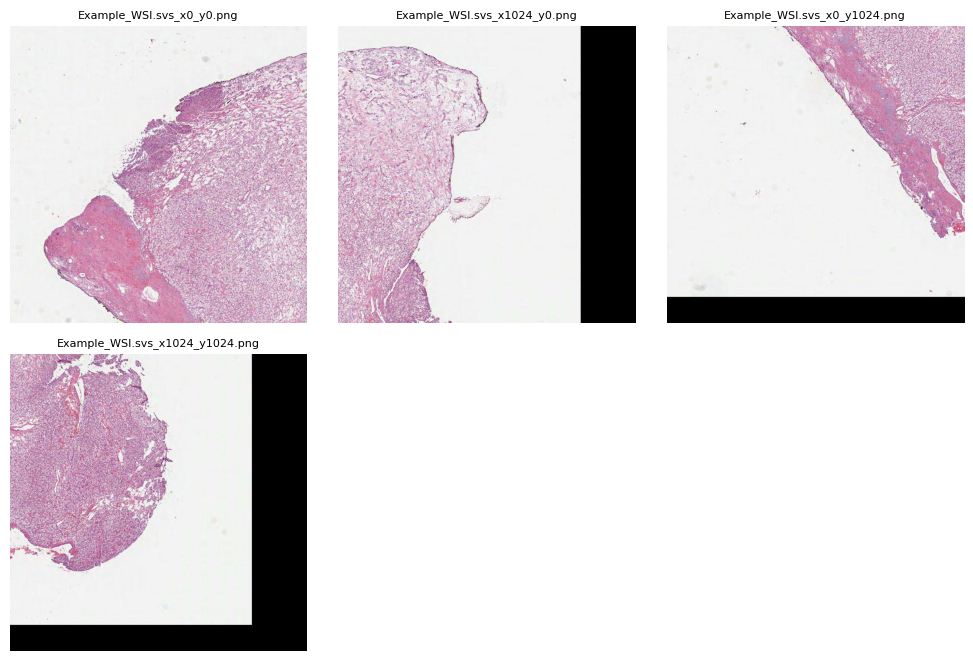

Total number of valid patches: 4


In [8]:
display_patches_with_titles(valid_patches, patch_names, max_patches=9)

**Call** the `extract_patches` function again, but in this case set the patch_level=1 and display the patches with the function `display_patches_with_titles` and answer the following question, what is happening?

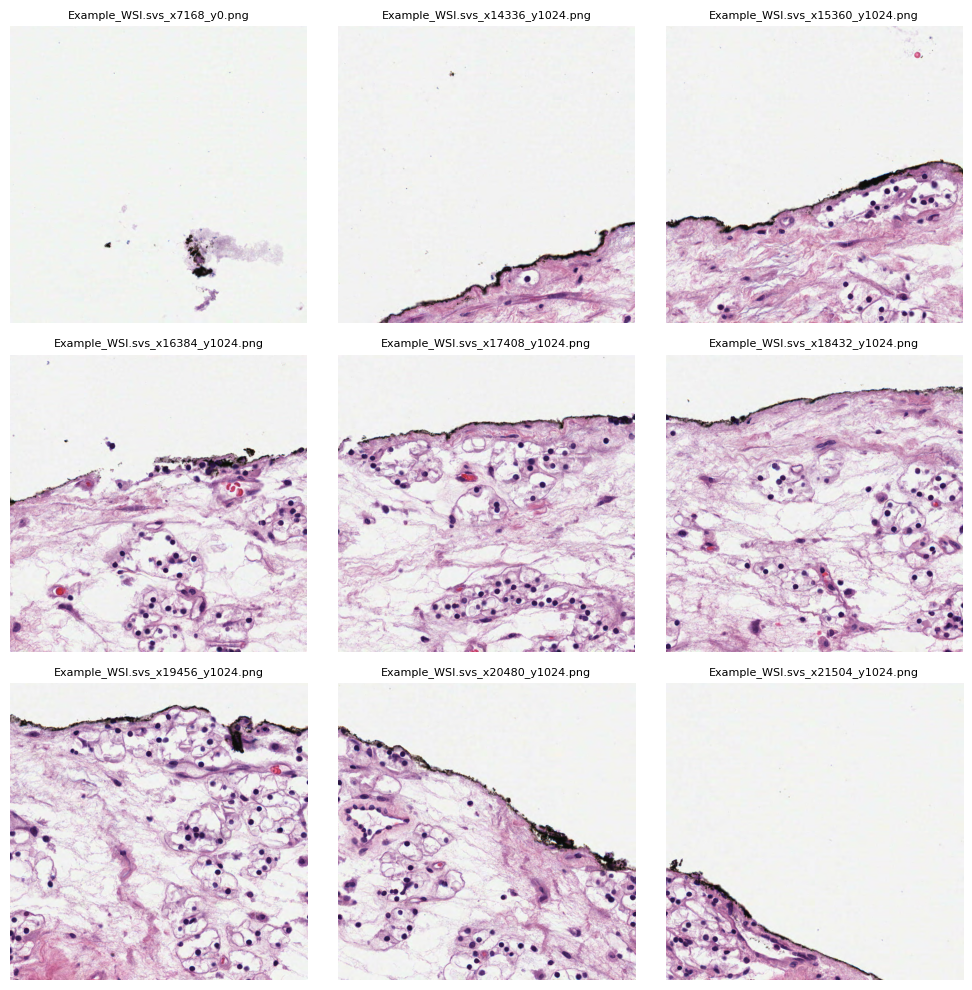

Total number of valid patches: 426


In [9]:
valid_patches, patch_names = extract_patches(path="/content/drive/MyDrive/Practica2",
    slide_id="Example_WSI.svs",
    patch_size=1024,
    patch_level=0,
    path_patches= "/content/drive/MyDrive/Practica2/patches_png",
    save_patches=False
)

display_patches_with_titles(valid_patches,patch_names,max_patches=9)

#what is happening?
#When patch_level=1 is used, the whole slide image (WSI) is downsampled. At this level, the spatial resolution is reduced by a factor corresponding to the level


**Exercise 2:** **Feature Extraction from Image Patches Using the CONCH Model**.
In this exercise, students will apply feature extraction techniques to a set of pre-processed image patches using the CONCH Vision-Language Model. The goal is to convert each patch into a numerical feature representation (embedding), which can be used for downstream tasks such as classification or clustering.

You will work with a dataset of image patches, provided in the form of a variable `valid_patches`, which contains a set of **PIL Image objects**. Using a pre-trained **CONCH model**, you will extract meaningful features for
each patch. These features can be stored for later use or further processing.

Steps:


1.   **Load the Pre-trained CONCH Model**: The CONCH model is pre-trained on vision-language tasks and will be used to extract features from the image patches.

2.   **Preprocess and Feed Patches into the Model**: Each patch in valid_patches will be preprocessed using the CONCH model’s preprocessing function before being passed through the model to extract the feature embeddings.

3.  **Save and Analyze the Features**: Once the feature vectors are extracted, they will be saved in a .npy file for future use.

Additionally, Check out the GITHUB DE CONCH repository https://github.com/mahmoodlab/CONCH/blob/main/README.md and write a summary of the main findings.

First, clone the following repository https://github.com/mahmoodlab/CONCH.git

In [10]:
!git clone https://github.com/mahmoodlab/CONCH.git
%cd CONCH

Cloning into 'CONCH'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 93 (delta 36), reused 30 (delta 28), pack-reused 35 (from 1)
Receiving objects: 100% (93/93), 1.22 MiB | 3.89 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/CONCH


In [11]:
!pip install timm #Look that is the library timm

**Next** we are going to extract the features of the patches extracted in the previous exercise, for this we are going to use the CONCH.bin model

In [12]:
 import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from conch.open_clip_custom import create_model_from_pretrained #Function of the github of conch

# Initialize device (GPU if available "cuda")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CONCH model and preprocessing pipeline
model_CONCH, preprocess_CONCH = create_model_from_pretrained("conch_ViT-B-16", checkpoint_path="/content/drive/MyDrive/Practica2/CONCH.bin") #Change the directory
#Send the model to device available
model_CONCH.to(device)

#Sets the eval mode in the model
model_CONCH.eval()

# Assuming valid_patches is a list of PIL images (the patches)
patch_emb_CONCH = []

# Loop through valid patches and extract features
for img in tqdm(valid_patches):
    # Preprocess each patch
    img_conch = preprocess_CONCH(img).unsqueeze(dim=0).to(device)

    # Extract features from the CONCH model
    with torch.inference_mode() and torch.no_grad():
        # Get the image embedding/feature vector from model use encode_image method with  proj_contrast=False and normalize=False. Make a squeeze, send the vector to cpu and convert to numpy.
        x = model_CONCH.encode_image(img_conch, proj_contrast=False, normalize=False).squeeze().cpu().numpy()

    # Append the feature vector to the list
    patch_emb_CONCH.append(x)

# Convert the list of feature vectors to a NumPy array. Look the documentation for the stack function
patch_features = np.stack(patch_emb_CONCH)

# Save the extracted features to a .npy file
np.save("/content/drive/MyDrive/Practica2/patch_features_CONCH.npy", patch_features) #Change the folder

# Optionally, print the shape of the extracted features
print(f"Extracted features shape: {patch_features.shape}")

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/content/CONCH/conch/open_clip_custom/factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Extracted features shape: (426, 512)


In thi part, we will use t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the extracted features. Dimensionality reduction allows us to visualize high-dimensional data in a 2D space, making it easier to interpret. Look the documentation of `TSNE`.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


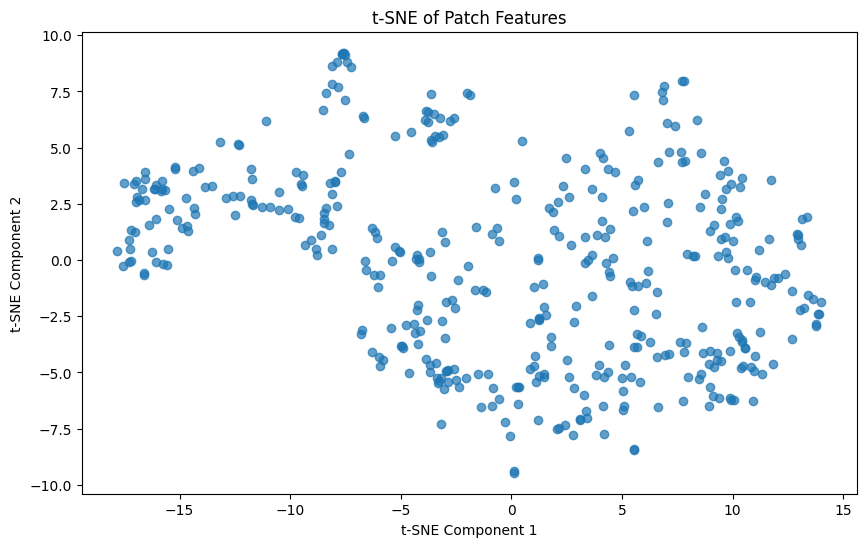

In [13]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 2D. n_components=2, perplexity=30, n_iter=300
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
# Apply the transformation of the previous line
tsne_features = tsne.fit_transform(patch_features)

# Plot the t-SNE reduced features
plt.figure(figsize=(10, 6))
#Make a scatter to visualize the tsne_features
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.7) #(X)
plt.title('t-SNE of Patch Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

**Exercice 3.** In this exercise, you will implement a Multiple Instance Learning (MIL) algorithm using PyTorch to classify whole slide images (WSI) of renal carcinoma into three different classes: (0) Clear Cell Adenocarcinoma, (1) Renal Cell Carcinoma, Chromophobe Type, and (2) Papillary Adenocarcinoma.

Each WSI is divided into smaller patches (instances), and each WSI is treated as a bag containing multiple patches. The objective is to classify the entire bag (WSI) based on the collective information from the patches.

You will design a neural network-based MIL model that takes as input a** bag of instances (patches)** and outputs a prediction for the **whole bag (WSI)**. To combine the information from individual patches, implement an aggregation function such as mean pooling (you can try also with max pooling). Train your model using **cross-entropy loss**, considering potential imbalances in the dataset by employing techniques like **weighted loss**  in the loss function. Use an optimizer such as Adam for training, and evaluate the model using accuracy, precision, recall, F1-score, and a **confusion matrix**.

In [14]:
import numpy as np
import random
import torch

np.random.seed(42)
# Set seed for Python's built-in random module
random.seed(42)
# Set seed for PyTorch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Next, we will decompress all the features that have been previously extracted to save time and computational cost. Note that each file contains the features of all the patches of a WSI.

In [15]:
folder_features = '/content/drive/MyDrive/Practica2/CONCH' #Change your folder
!unzip -qo "$folder_features" -d "/content/drive/MyDrive/Practica2" #Change your folder
#Take few minutes

unzip:  cannot find or open /content/drive/MyDrive/Practica2/CONCH, /content/drive/MyDrive/Practica2/CONCH.zip or /content/drive/MyDrive/Practica2/CONCH.ZIP.


We will create the `load_data_subset` function to read the embeddings and labels found in the csv of train, validation and test.

In [16]:
import pandas as pd  # Importing the pandas library for data manipulation
from tqdm import tqdm  # Importing tqdm for showing progress bars

def load_data_subset(folder, set_data):
    # Construct the path to the CSV file (e.g., for train, validation, or test set)
    csv_file = os.path.join(folder, "csv", set_data + ".csv")
    # Read the CSV file using pandas. It contains information such as WSI names and labels
    data = pd.read_csv(csv_file)

    # Extract the list of Whole Slide Images (WSI) names from the 'WSI' column of the CSV
    list_WSI = data['WSI'].tolist()

    # Extract the corresponding ground truth labels (GT) from the 'GT' column and convert to array
    labels = np.array(data['GT'].tolist())

    # For each WSI in the list, load the corresponding patch embeddings (stored as .npy files)
    # and store them in a list. The tqdm function is used to show the loading progress.
    patch_embd = [np.load(os.path.join(folder, 'CONCH', file_name + ".npy")) for file_name in tqdm(list_WSI)]

    # Return the loaded patch embeddings and the associated labels
    return patch_embd, labels


In [17]:
# Print information about the data loading process
print("[INFO] Loading dataframe")

# Define the folder path where the data is stored
folder = "/content/drive/MyDrive/Practica2" #Change your folder

# Load the training data and labels using the load_data_subset function
train_data, train_labels = load_data_subset(folder, "train")
# Load the validation data and labels
val_data, val_labels = load_data_subset(folder, "val")
# Load the test data and labels
test_data, test_labels = load_data_subset(folder, "test")
# Determine the number of unique classes in the validation set (or any set, as they should be consistent)
n_classes = len(np.unique(val_labels))
# Get the dimensionality of the patch embeddings (L represents the feature length of each patch)
L = train_data[0].shape[-1]

[INFO] Loading dataframe


100%|██████████| 261/261 [02:53<00:00,  1.50it/s]


[INFO] Visualizing class distribution...


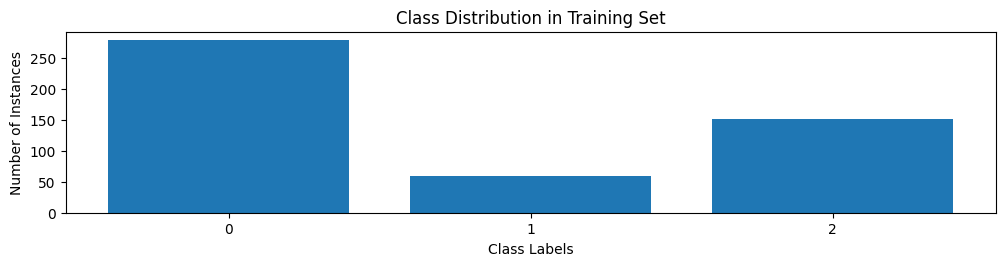

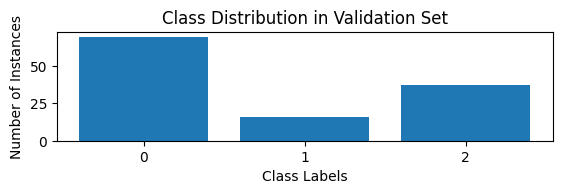

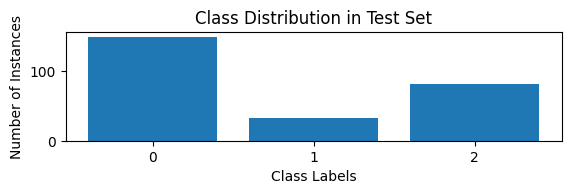

In [18]:
# Function to plot the class distribution
def plot_class_distribution(labels, title):
   # Get the unique labels and their respective counts, use unique from numpy and explore the parameter  return_counts
    unique, counts = np.unique(labels, return_counts=True)
    # Create a bar plot
    plt.bar(unique, counts)  # Create a bar plot for the class distribution
    plt.title(title)  # Set the title of the plot
    plt.xlabel('Class Labels')  # Set the x-axis label
    plt.ylabel('Number of Instances')  # Set the y-axis label
    plt.xticks(unique)  # Set the ticks on the x-axis to match the unique classes
    plt.show()  # Display the plot

# Plot the class distributions for training, validation, and test sets
print("[INFO] Visualizing class distribution...")
plt.figure(figsize=(12, 8))

# Plot class distribution for the training set
plt.subplot(3, 1, 1)
plot_class_distribution(train_labels, 'Class Distribution in Training Set')

# Plot class distribution for the validation set
plt.subplot(3, 1, 2)
plot_class_distribution(val_labels, 'Class Distribution in Validation Set')

# Plot class distribution for the test set
plt.subplot(3, 1, 3)
plot_class_distribution(test_labels, 'Class Distribution in Test Set')

Next we are going to define the model we will use

In [28]:
# Import the torch library for PyTorch functionality
import torch

# Define a class for the BGAP (Bag Global Average Pooling) model, which inherits from torch.nn.Module
class BGAP(torch.nn.Module):
    def __init__(self, n_classes, L):

        """
        Initializes the BGAP model.
        Parameters:
        n_classes: int - The number of output classes for classification.
        L: int - The dimensionality of the input features (feature length of each patch).
        """
        super(BGAP, self).__init__()  # Initialize the parent class (torch.nn.Module)

        # Store the feature length (L) as a class attribute
        self.L = L
        # Define the classifier as a fully connected (linear) layer. It maps the averaged feature embedding of size L to the number of classes (n_classes)
        self.classifier = torch.nn.Linear(L, n_classes)

    def forward(self, features):
        """
        Forward pass for the BGAP model.
        Parameters:
        features: torch.Tensor - Input feature tensor, typically the patch embeddings for a WSI.
        Returns:
        output: torch.Tensor - The classification output (logits for each class).
        embedding: torch.Tensor - The averaged feature embedding (global representation of the WSI).
        """
        # Compute the global average pooling of the input features along the 0th dimension (mean across all patches)
        embedding = torch.mean(features, dim=0)
        # Pass the averaged embedding through the classifier (fully connected layer) to get the output logits
        output = self.classifier(embedding)
        # Return the classification output and the averaged embedding
        return output, embedding

# Instantiate the BGAP model, specifying the number of classes and the feature length (L). The .cuda() method moves the model to the GPU for faster computation (if GPU is available)
n_classes = 5
L = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BGAP(n_classes, L).to(device)

In [50]:
#Function to plot the curve
def plot_figures(train_acc_epoch,test_acc_epoch,train_loss_epoch, test_loss_epoch, run_name):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Plotting training and testing losses
    axs[0].plot(train_loss_epoch, label='Train Loss')
    axs[0].plot(test_loss_epoch, label='Test Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting training and testing accuracies
    axs[1].plot(train_acc_epoch, label='Train ACC')
    axs[1].plot(test_acc_epoch, label='Test ACC')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()

*Let* us define the function that will carry out the training of the Multiple instance learning (MIL) model.

In [49]:
import numpy as np
import torch

def train_model(model, optimizer, criterion, scheduler, train_data, train_labels, test_data, test_labels, epochs, run_name):
    """
    Function to train a model and track its performance over multiple epochs.

    Parameters:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for updating the model's parameters.
    - criterion: The loss function (e.g., cross-entropy).
    - scheduler: A learning rate scheduler to adjust the learning rate during training.
    - train_data: The training data (list of feature batches).


    - train_labels: The labels corresponding to the training data.
    - test_data: The test data (list of feature batches).
    - test_labels: The labels corresponding to the test data.
    - epochs: Number of training epochs.
    - run_name: A name for the training run, used for labeling plots.

    Returns:
    - None: The function trains the model and plots the accuracy and loss per epoch.
    """

    # Lists to track accuracy and loss during training and validation/testing
    train_acc_epoch, test_acc_epoch, train_loss_epoch, test_loss_epoch = [], [], [], []

    # Main loop for training over multiple epochs
    for epoch in range(epochs):
        # Shuffle the training data and labels at the start of each epoch
        indices = np.random.permutation(len(train_labels))  # Random permutation of indices
        train_data = [train_data[idx] for idx in indices]
        train_labels = train_labels[indices]

        # Set the model to training mode
        model.train()

        # Initialize running accuracy and loss for training
        run_train_acc, run_test_acc = 0.0, 0.0
        run_train_loss, run_test_loss = 0.0, 0.0

        # Iterate over each batch in the training data
        for it, batch in enumerate(train_data):
            # Reset gradients for each batch
            optimizer.zero_grad()

            # Convert the batch to a tensor and move it to the GPU (if available)
            batch = torch.tensor(batch, dtype=torch.float32).cuda()

            # Forward pass through the model to get predictions (logits)
            train_logits, _ = model(batch)

            # Convert train_labels to tensor and move to GPU
            labels = torch.tensor(train_labels[it], dtype=torch.long).cuda()

            # Compute the loss between the predictions and true labels
            loss = criterion(train_logits, labels)

            # Backpropagation: compute gradients and update model parameters
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update weights using optimizer

            # Calculate the prediction by finding the class with the highest probability
            train_pred = train_logits.argmax(dim=1)

            # Update running accuracy and loss for training
            run_train_acc += (train_pred == labels).sum().item()  # Count correct predictions
            run_train_loss += loss.item()  # Accumulate the loss

        # Calculate average accuracy and loss for this epoch (training)
        train_acc = run_train_acc / len(train_labels)
        train_loss = run_train_loss / len(train_data)

        # Step the learning rate scheduler
        scheduler.step()

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient calculation during evaluation
        with torch.no_grad():
            for it, batch in enumerate(test_data):
                # Convert the batch to a tensor and move it to the GPU (if available)
                batch = torch.tensor(batch, dtype=torch.float32).cuda()

                # Forward pass through the model (evaluation mode)
                test_logits, _ = model(batch)

                # Convert test_labels to tensor and move to GPU
                labels = torch.tensor(test_labels[it], dtype=torch.long).cuda()

                # Compute the loss for this batch in the test data
                test_loss = criterion(test_logits, labels)

                # Calculate the predicted class
                test_pred = test_logits.argmax(dim=1)

                # Update running accuracy and loss for testing
                run_test_acc += (test_pred == labels).sum().item()  # Count correct predictions
                run_test_loss += test_loss.item()  # Accumulate the loss

        # Calculate average accuracy and loss for this epoch (testing/validation)
        test_acc = run_test_acc / len(test_labels)
        test_loss = run_test_loss / len(test_data)

        # Print the performance metrics for this epoch
        print('-------------------------------------------------------------------------')
        print(f'Epoch {epoch + 1} \t Training Loss = {train_loss:.4f} \t Validation Loss = {test_loss:.4f}')
        print(f'         \t Training Acc  = {train_acc:.4f} \t Validation Acc  = {test_acc:.4f}')
        print('-------------------------------------------------------------------------')

        # Append accuracy and loss for this epoch to the respective lists
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)

    # Plot accuracy and loss over the epochs using a custom plot_figures function
    plot_figures(train_acc_epoch, test_acc_epoch, train_loss_epoch, test_loss_epoch, run_name)
    # Return training metrics for further analysis
    return train_acc_epoch, test_acc_epoch, train_loss_epoch, test_loss_epoch



We set the hyperparameters and call the function that will train the model.

In [22]:
import torch
print(torch.cuda.is_available())


True


In [48]:
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.utils.class_weight import compute_class_weight


# Set the values for different hyperparameters

batch_size, weight_decay, adamw_beta, peak_learning_rate, epochs = 1, 1e-5, (0.9, 0.999), 1e-5, 20
# Define the optimizer using AdamW (Adam with weight decay) to update the model parameters
optimizer = AdamW(model.parameters(), lr=peak_learning_rate, betas=adamw_beta, weight_decay=weight_decay)
# CosineAnnealingLR: gradually decreases the learning rate following a cosine annealing schedule (T_max=epochs: sets the period (the maximum number of iterations) after which the learning rate reaches its minimum)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Compute the class weights to handle class imbalance in the dataset (give more importance to underrepresented classes). Use the funcion compute_class_weight
#With the following arguments:
# - 'balanced': calculates weights inversely proportional to the class frequencies
# - classes: specifies the unique classes in the dataset (from the train_labels)
# - y=train_labels: the actual labels in the training set, used to calculate the class frequencies
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

# Convert the computed class weights to a tensor and move it to the GPU
class_weights = torch.tensor(class_weights, dtype=torch.float32)


# Define the loss function (criterion) as cross-entropy loss
# - weight=class_weights: applies the class weights to the loss function to handle class imbalance
# - reduction="sum": sums the loss over all instances, which will be used during backpropagation
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction="sum")

# Define a name for the experiment, which can be used for logging or plotting results
run_name = "Experiment_Global-Average-Pooling"


def train_model(model, optimizer, criterion, scheduler, train_data, train_labels, val_data, val_labels, epochs, run_name):
    for epoch in range(epochs):
        model.train()
        # Implement training logic here, e.g., forward pass, backward pass, etc.
        print(f"Epoch {epoch + 1}/{epochs}: Training...")

        # Implement validation logic here
        model.eval()
        print(f"Epoch {epoch + 1}/{epochs}: Validation...")

        # Update learning rate
        scheduler.step()
# Call the train_model function to start training the model

# Parameters:
# - model: the neural network model to be trained
# - optimizer: the AdamW optimizer to update the model's parameters
# - criterion: the cross-entropy loss function with class weights
# - scheduler: the cosine annealing scheduler to adjust the learning rate
# - train_data: the training dataset (features/patches)
# - train_labels: the training labels corresponding to the data
# - val_data: the validation dataset (used for evaluating the model during training)
# - val_labels: the validation labels
# - epochs: the number of epochs for which the model will be trained
# - run_name: the name of the experiment used for logging results and plots
train_model(model, optimizer, criterion, scheduler, train_data, train_labels, val_data, val_labels, epochs, run_name) #(X)

Epoch 1/20: Training...
Epoch 1/20: Validation...
Epoch 2/20: Training...
Epoch 2/20: Validation...
Epoch 3/20: Training...
Epoch 3/20: Validation...
Epoch 4/20: Training...
Epoch 4/20: Validation...
Epoch 5/20: Training...
Epoch 5/20: Validation...
Epoch 6/20: Training...
Epoch 6/20: Validation...
Epoch 7/20: Training...
Epoch 7/20: Validation...
Epoch 8/20: Training...
Epoch 8/20: Validation...
Epoch 9/20: Training...
Epoch 9/20: Validation...
Epoch 10/20: Training...
Epoch 10/20: Validation...
Epoch 11/20: Training...
Epoch 11/20: Validation...
Epoch 12/20: Training...
Epoch 12/20: Validation...
Epoch 13/20: Training...
Epoch 13/20: Validation...
Epoch 14/20: Training...
Epoch 14/20: Validation...
Epoch 15/20: Training...
Epoch 15/20: Validation...
Epoch 16/20: Training...
Epoch 16/20: Validation...
Epoch 17/20: Training...
Epoch 17/20: Validation...
Epoch 18/20: Training...
Epoch 18/20: Validation...
Epoch 19/20: Training...
Epoch 19/20: Validation...
Epoch 20/20: Training...
Epoch

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In this part of the exercise, we are going to evaluate the trained model's performance on the val and test dataset. Addionally, we are going to calculate the confusion matrix. A confusion matrix is a useful tool in classification tasks. Each row represents the actual class, and each column represents the predicted class. The diagonal elements show correct predictions, while the off-diagonal elements show misclassifications. This will help us analyze the model’s strengths and weaknesses, especially if we have an imbalanced dataset.



In [67]:
import numpy as np
import torch
from sklearn import metrics

def validate_model(model, test_data, test_labels):
    """
    Validates the model's performance on the test dataset and returns the confusion matrix.

    Parameters:
    - model: The trained neural network model to be evaluated.
    - test_data: The test dataset, which should be a DataLoader, list of feature batches, or a NumPy array.
    - test_labels: The ground truth labels corresponding to the test dataset.

    Returns:
    - conf_mx: Confusion matrix comparing the true labels to the model's predictions.
    """
    model.eval()
    list_test_pred = []
    list_true_labels = []

    # Ensure test_data is iterable
    if not hasattr(test_data, '__iter__'):
        raise ValueError("test_data must be an iterable object (e.g., DataLoader or list of batches).")

    with torch.no_grad():
        for it, batch in enumerate(test_data):
            # Debugging: Check type of batch
            print(f"Processing batch {it}, type: {type(batch)}")

            if isinstance(batch, (list, tuple)):  # Handle batch-label pair
                batch = batch[0]  # Assuming the first element is the data

            if not isinstance(batch, torch.Tensor):
                batch = torch.tensor(batch, dtype=torch.float32).cuda()

            test_logits, _ = model(batch) # Call model with batch to get predictions

            if isinstance(test_logits, tuple):  # Handle tuple outputs
                test_logits = test_logits[0]

            print(f"Shape of test_logits: {test_logits.shape}")  # Debugging shape

            # Get predictions and true labels for the current batch
            test_pred = test_logits.argmax(dim=-1).cpu().numpy()  # Get predicted class for each instance in the batch

            #Check if test_pred is a scalar and convert to a list if needed.
            if test_pred.shape == ():  # Checks if test_pred is a scalar
                test_pred = [test_pred]  # Convert the scalar value to a list

            true_labels_batch = [test_labels[it]] * len(test_pred)  # Replicate the true label for each instance in the batch

            # Extend the lists with the predictions and true labels for this batch
            list_test_pred.extend(test_pred)
            list_true_labels.extend(true_labels_batch)

    conf_mx = metrics.confusion_matrix(list_true_labels, list_test_pred)
    return conf_mx


In [68]:
#We developed a function to display the confusion matrix.
import seaborn as sns  # Import seaborn for advanced visualizations (heatmap in this case)

def plot_confmx(conf_matrix, run_name, subset=None):
    """
    Plots a confusion matrix as a heatmap and saves the plot as a PNG image.
    Parameters:
    - conf_matrix: The confusion matrix (2D array) to be plotted.
    - run_name: A string representing the name of the run/experiment, used for saving the plot.
    - subset: Optional; an additional identifier for the subset (e.g., train/test), used for saving the plot.
    Returns:
    - None: The function generates and saves the plot to a file.
    """

    # True Positives (TP) are the diagonal elements of the confusion matrix
    TP = np.diag(conf_matrix)
    # False Positives (FP) are the sum of each column (predicted class counts) minus the True Positives
    # False Negatives (FN) are the sum of each row (actual class counts) minus the True Positives
    FN = conf_matrix.sum(axis=1) - TP
    FP = conf_matrix.sum(axis=0) - TP
    # Balanced Accuracy (BALACC) is the mean of TP rate (TP / (TP + FN)) for each class
    bal_acc = np.mean(TP / (TP + FN))
    # Create a new figure for the plot, specifying its size
    plt.figure(figsize=(8, 6))
    # Plot the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    # Set labels for the x-axis (Predicted) and y-axis (True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Set the plot title, which includes the rounded balanced accuracy value
    plt.title('BALACC = ' + str(round(bal_acc, 4)))


In [70]:
print(f"Type of test_data: {type(test_data)}, length: {len(test_data)}")
print(f"Type of test_labels: {type(test_labels)}, length: {len(test_labels)}")


Type of test_data: <class 'list'>, length: 261
Type of test_labels: <class 'numpy.ndarray'>, length: 261


Processing batch 0, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 1, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 2, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 3, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 4, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 5, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 6, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 7, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 8, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 9, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 10, type: <class 'numpy.ndarray'>
Shape of test_logits: torch.Size([5])
Processing batch 11, type: <cla

<ipython-input-68-bdbb71c95815>:22: RuntimeWarning: invalid value encountered in divide
  bal_acc = np.mean(TP / (TP + FN))
<ipython-input-68-bdbb71c95815>:22: RuntimeWarning: invalid value encountered in divide
  bal_acc = np.mean(TP / (TP + FN))


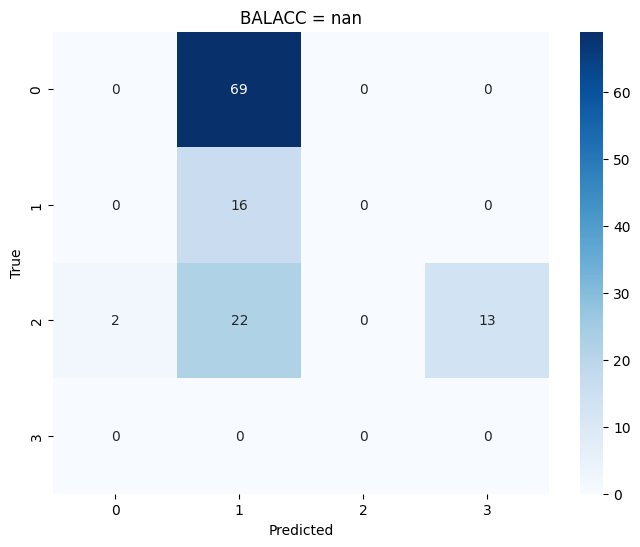

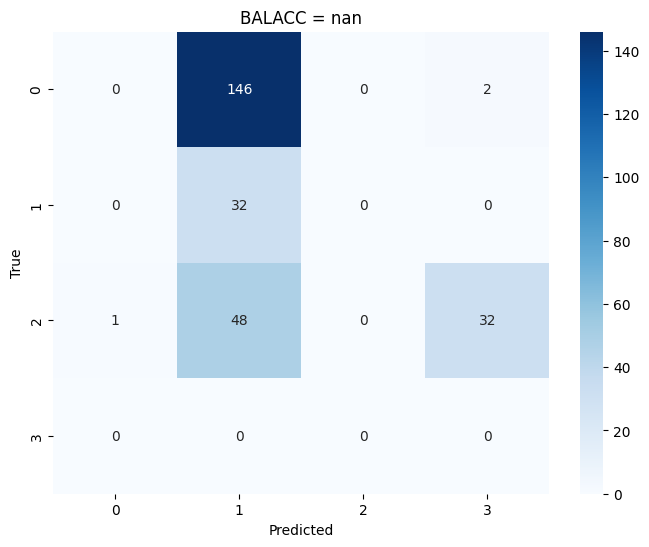

In [69]:
# Model validation/testing
val_cm = validate_model(model, val_data, val_labels)
test_cm = validate_model(model, test_data, test_labels)

# Plot the confusion matrix
val_bacc = plot_confmx(val_cm, run_name, subset='val')
test_bacc = plot_confmx(test_cm, run_name, subset='test')

torch.cuda.empty_cache()